In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize, SymLogNorm
from matplotlib import cm as colormap
import pandas as pd
import time
from string import ascii_lowercase
from scipy import special
from scipy.constants import mu_0, epsilon_0
import empymod
# SimPEG, discretize/
import discretize
from discretize import CylindricalMesh
import simpeg.electromagnetics.time_domain as tdem
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from geoana.em.tdem import ElectricDipoleWholeSpace
from geoana.em.tdem import vertical_magnetic_flux_time_deriv_horizontal_loop
from geoana.em.tdem import diffusion_distance
from geoana.em.tdem import peak_time
from geoana.utils import ndgrid
from pymatsolver import Pardiso

import ipywidgets
eps = np.finfo(float).eps

## Define and plot Mesh

In [2]:
tx_radius = (3.5)/(np.sqrt(np.pi))
print(f"radius of transmitter: {tx_radius}")

radius of transmitter: 1.9746635424171473


In [3]:
csx, csz = tx_radius/4.,tx_radius/4.
ncx, ncz  = 100, 100 
# ncx, ncz  = 200, 200 
pf, npadx, npadz = 1.3 , 26, 26
mesh = CylindricalMesh(
    [[(csx, ncx), (csx, npadx, pf)], [np.pi*2], [(csz, npadz, -pf), (csz, 2*ncz), (csz, npadz, pf)]], 
    origin = "000"
)
mesh.origin = np.r_[0, 0, -mesh.h[2][:npadz+ncz].sum()]
print(f"Cell size: {csx}, number of cells in center: {ncx}")
tx_height = csx

Cell size: 0.4936658856042868, number of cells in center: 100


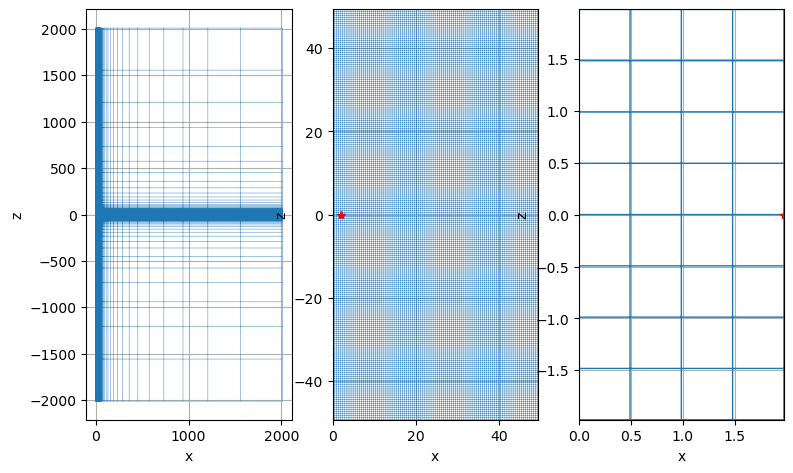

In [4]:
fig, ax = plt.subplots(1,3, figsize=(9,7))
ax[0] = mesh.plot_grid(ax=ax[0], show_it=False, linewidth=0.3)  
ax[0].set_aspect('equal')
ax[1] =  mesh.plot_grid(ax=ax[1], show_it=False, linewidth=0.3)
#ax[1] =  mesh.plot_grid(show_it=True)
ax[1].set_xlim(0., ncx*csx)
ax[1].set_ylim(-ncz*csz , ncz*csz )
ax[1].set_aspect('equal')
ax[1].plot(tx_radius,0,'r*')
ax[2] =  mesh.plot_grid(ax=ax[2], show_it=False, linewidth=1.0)
ax[2].set_xlim(0.,tx_radius)
ax[2].set_ylim(-tx_radius,tx_radius)
ax[2].set_aspect('equal')
ax[2].plot(tx_radius,0,'r*')


## Plot model 

In [5]:
sigma_air = 1e-8
sigma_sea = 3.3
thick_sea = 1000.1
depth_seabed = 15.0
sigma_seabed = 1.0
sigma_target = 5.0
rc_block = 0
rd_block = 50.
zc_block = -tx_height-15.
zd_block = 30.
#tx_height = 0.5
tx_current = 1

In [6]:
ind_block = (((mesh.cell_centers[:, 2] < - tx_height) & 
            (mesh.cell_centers[:, 2] > -( tx_height + zd_block))  &
            (mesh.cell_centers[:, 0] < rd_block/2.))) 
print(np.ones(ind_block.sum(),dtype=bool))

[ True  True  True ...  True  True  True]


## Set Up mapping

In [7]:
## 
#parametric_map = maps.ParametricBlock(mesh, indActive=ind_active, slope=20, epsilon=1e-06, p=10)
# ind_block = (((mesh.cell_centers[:, 2] < - tx_height) & 
#             (mesh.cell_centers[:, 2] > -( tx_height + zd_block))  &
#             (mesh.cell_centers[:, 0] < rd_block/2.))) 
ind_active = mesh.cell_centers[:, 2] < -tx_height
active_map = maps.InjectActiveCells(mesh= mesh,
             indActive=ind_active, valInactive=np.log(sigma_sea))

projection_map = maps.SurjectUnits(indices= [np.ones(ind_active.sum(),dtype=bool)])
## Kill indices for the seawater

## Exponential map to convert the model to conductivity
exp_map = maps.ExpMap(mesh)
model_map = exp_map*active_map *  projection_map
#model_map = exp_map*active_map *  parametric_map

In [8]:
# model_ref   = np.r_[np.log(sigma_sea) , np.log(sigma_sea), rc_block, rd_block, 0 , 2.*np.pi, zc_block, zd_block]
# model_block = np.r_[np.log(sigma_seabed), np.log(sigma_target), rc_block, rd_block, 0 , 2.*np.pi, zc_block, zd_block]
model_ref= np.r_[np.log(sigma_sea)]
model_block = np.r_[np.log(sigma_target)]
sigma_ref = model_map * model_ref
sigma_block = model_map * model_block
#model = np.r_[sigma_seabed, 2, rc_block, rd_block, 0 , 2.*np.pi, zc_block, zd_block]

In [9]:
def plot_two_model(model_1, model_2, range_x = [-40.,40.], range_y = [-40.,20.], ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1,2, figsize=(8,5))
    view="sigma"
    min_field, max_field = None, None
    mirror_data=None
    v_type = "CC"
    view_type="real"  
    plot_me_1 = model_map * model_1
    plot_me_2 = model_map * model_2
    norm = LogNorm(vmin=min(np.r_[plot_me_1, plot_me_2]),
                   vmax=max(np.r_[plot_me_1, plot_me_2]))
    cb = plt.colorbar(mesh.plot_image(
        plot_me_1, v_type= v_type, view=view_type, 
        range_x=range_x, range_y=range_y,
        pcolor_opts={'norm': norm}, stream_opts= {'color': 'w'}, 
        stream_threshold=min_field, mirror=True, ax=ax[0], 
    )[0], ax=ax[0])
    cb.set_label(view) 
    cb = plt.colorbar(mesh.plot_image(
        plot_me_2, v_type= v_type, view=view_type, 
        range_x=range_x, range_y=range_y,
        pcolor_opts={'norm': norm}, stream_opts= {'color': 'w'}, 
        stream_threshold=min_field, mirror=True, ax=ax[1], 
    )[0], ax=ax[1])
    cb.set_label(view) 
    for a in ax:
        a.plot([-tx_radius,tx_radius],[0,0],'r*-')
        a.set_aspect('equal')
        a.set_xlabel("x (m)")
        a.set_ylabel("z (m)")
    return ax


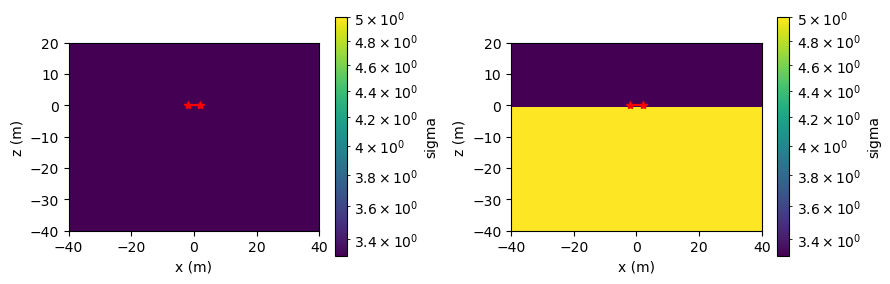

In [10]:
fig, ax = plt.subplots(1,2, figsize=(9,3))
plot_two_model(model_1=model_ref, model_2=model_block,ax=ax)
plt.tight_layout()

## Define Time steps

In [11]:
time_steps = [(2e-6,  150),  (5e-6,  150),  (2e-5,  150), (5e-5,  150)]
tstrt, tend = 1e-5, 1e-2

steps = np.array([])
for i in range(len(time_steps)):
    dt, n = time_steps[i]
    step_array = dt * np.ones(n)
    steps = np.concatenate((steps, step_array))
time_clc = np.cumsum(steps)
rmp_time = time_clc[0]
time_clc = time_clc[time_clc < rmp_time + tend+eps ]

In [12]:
## define time to recorded at receiver
time_rec = np.logspace(np.log10(1e-5), np.log10(1e-2), 31)

In [13]:
waveform=tdem.sources.StepOffWaveform()

rx_z = tdem.receivers.PointMagneticFluxTimeDerivative(
    np.r_[0, 0, 0], times=time_rec, orientation="z"
)
src = tdem.sources.CircularLoop(
    location=np.r_[0, 0, 0], radius=tx_radius, receiver_list=[rx_z],
    waveform=waveform, n_turns=5,
)
survey = tdem.Survey([src])
sim = tdem.simulation.Simulation3DElectricField(
    mesh=mesh, survey=survey,  solver=Pardiso, time_steps=time_steps,
    sigmaMap=model_map
)


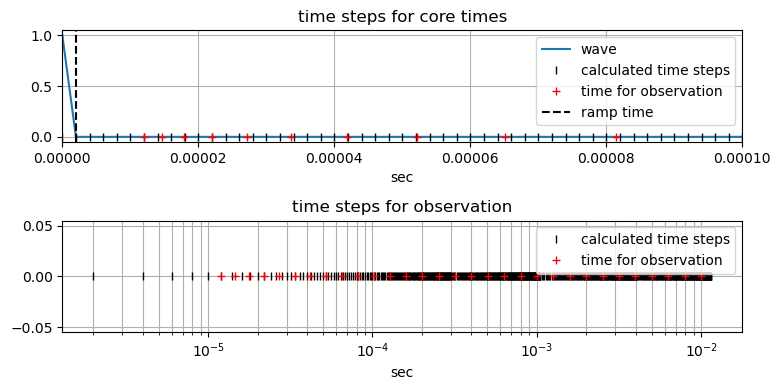

In [14]:
fig, ax = plt.subplots(2,1,figsize=(8,4))
ax[0].plot(sim.times, [waveform.eval(t) for t in sim.times],label='wave')
ax[0].plot(sim.times, np.zeros_like(sim.times), "|k",label='calculated time steps')
ax[0].plot(time_rec+rmp_time, np.zeros_like(time_rec), "+r",lw=3,label='time for observation')
ax[0].axvline(rmp_time, color='k', linestyle='--',label='ramp time')
ax[0].set_xlim(0,1e-4)#time_steps[0][0]*time_steps[0][1])
ax[0].set_title('time steps for core times')

ax[1].semilogx(sim.times, np.zeros_like(sim.times), "|k",label='calculated time steps')
ax[1].semilogx(time_rec+rmp_time, np.zeros_like(time_rec), "+r",lw=3,label='time for observation')
ax[1].set_title('time steps for observation')

for a in ax:
    a.grid(which='both')
    a.set_xlabel('sec')
    a.legend()
plt.tight_layout()
plt.show()

## Get observation from forwad simulation

In [15]:
sim_block =sim.dpred(model_block)
sim_ref = sim.dpred(model_ref)
dobs_block = -sim_block*np.pi*tx_radius**2
dobs_ref = -sim_ref*np.pi*tx_radius**2


In [16]:
relative_error = 0.01
noise_floor = 1e-7/(np.pi*tx_radius**2)
sim_block_noisy = (sim_block +
     np.random.randn(len(sim_block)) * relative_error * np.abs(sim_block) +
     np.random.randn(len(sim_block)) * noise_floor 
     )
dobs_block_noisy = -sim_block_noisy*np.pi*tx_radius**2

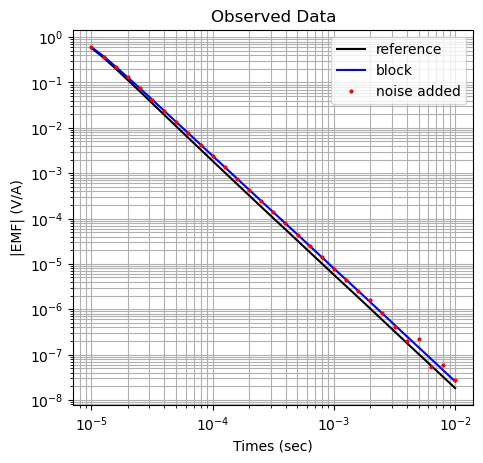

In [17]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax.loglog(time_rec, np.abs(dobs_ref), "k-", markersize=2 , label='reference')
ax.loglog(time_rec, np.abs(dobs_block), "b-", markersize=2, label='block')
ax.loglog(time_rec, np.abs(dobs_block_noisy), "ro", markersize=2, label='noise added')
ax.legend()
ax.grid(which="both")
ax.set_xlabel("Times (sec)")
ax.set_ylabel("|EMF| (V/A)")
ax.set_title("Observed Data")

plt.show()

## Assign uncertainties

In [18]:
# # 5% of the absolute value

# uncertainties = 0.01 * np.abs(sim_block_noisy) * np.ones(np.shape(sim_block))
# print(uncertainties)

## Defining The data

In [19]:

#data_object = data.Data(survey, dobs=dobs_noisy, standard_deviation=uncertainties)

data_object = data.Data(survey, dobs=sim_block_noisy, relative_error=relative_error, noise_floor=noise_floor)

## Starting/Reference model

In [20]:
# # Starting model is log-conductivity values (S/m)
# starting_conductivity_model = model_ref

# # Reference model is also log-resistivity values (S/m)
# reference_conductivity_model = starting_conductivity_model.copy()

In [21]:
simulation_L2 = tdem.simulation.Simulation3DElectricField(
    mesh=mesh, survey=survey,  solver=Pardiso, time_steps=time_steps,
    sigmaMap=model_map,
)

## Data Misfit

In [22]:
dmis_L2 = data_misfit.L2DataMisfit(simulation=simulation_L2, data=data_object)

## Regularization

In [23]:
# Smoothest inversion
#alpha_s = 1
# alpha_x = 1
# alpha_y = 1
# alpha_z = 1

#reg_s = regularization.Smallness(mesh=mesh,mapping=model_map, reference_model= model_ref)
#reg_s = regularization.Smallness(mesh=mesh,reference_model= sigma_ref)

# reg_x = regularization.SmoothnessFirstOrder(mesh, orientation="x")
# reg_y = regularization.SmoothnessFirstOrder(mesh, orientation="y")
# reg_z = regularization.SmoothnessFirstOrder(mesh, orientation="z")

# reg_L2 = alpha_s * reg_s + alpha_x * reg_x + alpha_y * reg_y + alpha_z * reg_z
#reg_L2 = alpha_s * reg_s 
reg_L2 = regularization.Smallness(mesh=discretize.TensorMesh([1]))

# Optimization

In [24]:
maxIter, maxIterCG, maxIterLS = 10,50,10
opt_L2 = optimization.ProjectedGNCG(
            maxIter=maxIter, lower=np.r_[-np.inf], 
        maxIterCG=maxIterCG, maxIterLS=maxIterLS,
)

## Inverse Problem

In [25]:
#target_misfit = directives.TargetMisfit(chifact=0.5)
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

## Inversion Directives

In [26]:
# update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1)
beta_schedule = directives.BetaSchedule(coolingFactor=3.0, coolingRate=1)
target_misfit = directives.TargetMisfit(chifact=0.5)

directives_list_L2 = [starting_beta, beta_schedule, target_misfit]

#directives_list_L2 = directives.TargetMisfit(chifact=1.0)
#inversion_progress = SaveInversionProgress(results_file=f"{directory_path}/{filename_save}")

## Define and Run Inversion

In [27]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)


In [28]:

# Run the inversion
recovered_model_L2 = inv_L2.run(model_ref)
#recovered_model_L2 = inv_L2.run(sigma_ref)


Running inversion with SimPEG v0.22.0
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DElectricField problem***
                        


c:\Users\81805\anaconda3\envs\env_ubcgif\lib\site-packages\pymatsolver\direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format.
  self.solver = MKLPardisoSolver(
c:\Users\81805\anaconda3\envs\env_ubcgif\lib\site-packages\pymatsolver\direct.py:73: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format.
  self.solver.refactor(self.A)


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.23e+04  9.05e+03  0.00e+00  9.05e+03    3.41e+04      0              
   1  1.08e+04  1.60e+03  6.98e-02  2.35e+03    1.36e+04      0              
   2  3.58e+03  2.38e+02  1.31e-01  7.07e+02    5.37e+03      0   Skip BFGS  
   3  1.19e+03  4.77e+01  1.57e-01  2.36e+02    1.91e+03      0   Skip BFGS  
   4  3.98e+02  2.50e+01  1.67e-01  9.15e+01    6.52e+02      0   Skip BFGS  
   5  1.33e+02  2.24e+01  1.70e-01  4.50e+01    2.19e+02      0   Skip BFGS  
   6  4.42e+01  2.21e+01  1.71e-01  2.97e+01    7.33e+01      0   Skip BFGS  
   7  1.47e+01  2.21e+01  1.72e-01  2.46e+01    2.45e+01      0   Skip BFGS  
   8  4.92e+00  2.21e+01  1.72e-01  2.29e+01    8.16e+00      0   Skip BFGS  
   9  1.64e+00  2.21e+01

In [29]:
print(model_ref)
print(model_block)
print(recovered_model_L2)

[1.19392247]
[1.60943791]
[1.6084338]


## Plot inversion results

In [30]:
sim_rec =sim.dpred(recovered_model_L2)
dobs_rec = -sim_rec*np.pi*tx_radius**2

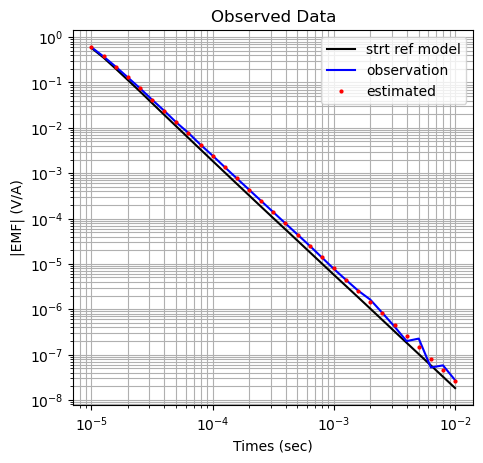

In [31]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax.loglog(time_rec, np.abs(dobs_ref), "k-", markersize=2, label='strt ref model') 
ax.loglog(time_rec, np.abs(dobs_block_noisy), "b-", markersize=2, label='observation')
ax.loglog(time_rec, np.abs(dobs_rec), "ro", markersize=2, label='estimated')
ax.grid(which="both")
ax.legend()
ax.set_xlabel("Times (sec)")
ax.set_ylabel("|EMF| (V/A)")
ax.set_title("Observed Data")

plt.show()

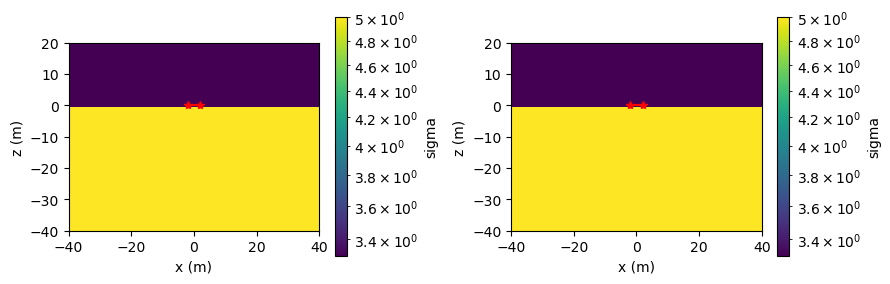

In [33]:
fig, ax = plt.subplots(1,2, figsize=(9,3))
plot_two_model(model_1=model_block, model_2=recovered_model_L2,ax=ax)
plt.tight_layout()